In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
import warnings
from scipy import stats
from sklearn import preprocessing, metrics, svm
from sklearn.linear_model import LogisticRegression
import os
warnings.filterwarnings('ignore')
pd.set_option('display.min_rows', 30)
pd.set_option('display.max_rows',150)
pd.set_option('display.width', 1000)

# Useful classes to have easier access to data features
class ColumnsInput:
    barcode = 'ddc_barcode'
    ipcode = 'ddc_ipcode'
    machine = 'ddc_mch_code'
    machine_side = 'ddc_mch_side'
    event = 'ddc_ev_subcode'
    time = 'ddc_ev_timestamp'
    
    
class ColumnsOutput:
    c_machine = 'c_machine' 
    event_delta_time = 'event_delta_time'
    day = 'y-m-day'
    month = 'month'
    status = 'status'

file_list = os.listdir('Data/data_per_machine/2022/')
print(file_list)
mach_name = [file.replace('.csv','') for file in file_list]
print(mach_name, len(mach_name))

['C403.csv', 'C103.csv', '1506.csv', 'C305.csv', 'C105.csv', 'C211.csv', '1306.csv', 'C603.csv', 'C210.csv', 'C605.csv', '1302.csv', 'C312.csv', '1501.csv', '1206.csv', 'C102.csv', 'C404.csv', '1402.csv', 'C307.csv', 'C207.csv', '1304.csv', '1406.csv', 'C511.csv', '1305.csv', 'C507.csv', '1301.csv', 'C608.csv', 'C612.csv', 'C209.csv', '1502.csv', '1403.csv', '1303.csv', 'C410.csv', 'C502.csv', 'C501.csv', '1507.csv', 'C407.csv', 'C412.csv', '1205.csv', 'C508.csv', '1404.csv', 'C303.csv', 'C111.csv', 'C610.csv', '1307.csv', 'C110.csv', 'C106.csv', 'C308.csv', 'C309.csv', 'C503.csv', '1407.csv', 'C202.csv', 'C509.csv', '1401.csv', 'C104.csv', 'C406.csv', '1203.csv', 'C601.csv', '1505.csv', 'C408.csv', 'C205.csv', 'C504.csv', 'C602.csv', 'C203.csv', 'C204.csv', 'C607.csv', 'C510.csv', 'C301.csv', 'C206.csv', 'C310.csv', 'C311.csv', 'C109.csv', '1201.csv', 'C411.csv', 'C512.csv', 'C101.csv', 'C405.csv', 'C401.csv', 'C505.csv', 'C201.csv', 'C409.csv', 'C302.csv', 'C606.csv', 'C609.csv', '15

In [187]:
def general_plot(x_, y_, x_bounds = None, y_bounds = None, title = None, x_title = None, y_title = None):
    fig, ax = plt.subplots(figsize=(15, 4))

    plt.xticks(rotation=90)
    plt.grid(True)
    
    if title is not None:
        plt.title(title)
    
    if x_title is not None:    
        plt.xlabel(x_title)
        
    if y_title is not None:    
        plt.ylabel(y_title)
    
    if (x_bounds is not None):
        plt.xlim(x_bounds)
               
    if (y_bounds is not None):
        plt.ylim(y_bounds)
    ax.plot(x_,y_, 'bo')
    
    plt.show()

# Set the machine to analyse with the index


In [188]:
mach_index = 40

In [189]:
df = pd.read_csv('Data/data_per_machine/2022/' + file_list[mach_index])
df[ColumnsInput.time] = pd.to_datetime(df[ColumnsInput.time])
current_machine = mach_name[mach_index]
days = df[ColumnsOutput.day].unique()
print(df.head())
print(df.info())


   Unnamed: 0  ddc_barcode  ddc_ipcode ddc_mch_code ddc_mch_side         ddc_ev_subcode    ddc_ev_timestamp  c_machine  month   y-m-day
0          26   9439685509       23511         C303            R     LO_LOADER_OUT_STOP 2022-10-10 00:00:01       True     10  22-10-10
1          27   9439685509       23511         C303            R  CL_UNLOCK_PRESS_START 2022-10-10 00:00:01       True     10  22-10-10
2          28   9439685508       23511         C303            L     LO_LOADER_OUT_STOP 2022-10-10 00:00:01       True     10  22-10-10
3          29   9439685508       23511         C303            L  CL_UNLOCK_PRESS_START 2022-10-10 00:00:01       True     10  22-10-10
4          38   9439685509       23511         C303            R   CL_UNLOCK_PRESS_STOP 2022-10-10 00:00:03       True     10  22-10-10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265156 entries, 0 to 265155
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------       

In [190]:
working_time_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day['work_time'] = (working_time_per_day['max'] - working_time_per_day['min']).dt.total_seconds()
print(working_time_per_day.shape)
print(working_time_per_day.head())

working_time_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.time].agg(['min', 'max']).reset_index()
working_time_per_day_per_arm['work_time'] = (working_time_per_day_per_arm['max'] - working_time_per_day_per_arm['min']).dt.total_seconds()
print(working_time_per_day_per_arm.head())
working_time_per_day_per_right = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)
working_time_per_day_per_left = working_time_per_day_per_arm[working_time_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
working_time_per_day_per_right.shape


(45, 4)
    y-m-day                 min                 max  work_time
0  22-10-10 2022-10-10 00:00:01 2022-10-10 23:59:57    86396.0
1  22-10-11 2022-10-11 00:00:00 2022-10-11 16:50:30    60630.0
2  22-10-12 2022-10-12 00:40:55 2022-10-12 23:59:57    83942.0
3  22-10-13 2022-10-13 00:00:02 2022-10-13 04:06:38    14796.0
4  22-10-14 2022-10-14 00:55:49 2022-10-14 07:46:42    24653.0
    y-m-day ddc_mch_side                 min                 max  work_time
0  22-10-10            L 2022-10-10 00:00:01 2022-10-10 23:59:57    86396.0
1  22-10-10            R 2022-10-10 00:00:01 2022-10-10 23:59:57    86396.0
2  22-10-11            L 2022-10-11 00:00:00 2022-10-11 16:50:30    60630.0
3  22-10-11            R 2022-10-11 00:00:00 2022-10-11 16:50:29    60629.0
4  22-10-12            L 2022-10-12 11:33:55 2022-10-12 23:59:57    44762.0


(45, 5)

In [191]:
mach_tyre_per_day = df.groupby([ColumnsOutput.day])[ColumnsInput.barcode].nunique().dropna().reset_index()
print(mach_tyre_per_day.shape)
mach_tyre_per_day_per_arm = df.groupby([ColumnsOutput.day, ColumnsInput.machine_side])[ColumnsInput.barcode].nunique().reset_index()
print(mach_tyre_per_day_per_arm.shape)
mach_tyre_per_day_per_left = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'L'].reset_index().drop('index', axis = 1)
mach_tyre_per_day_per_right = mach_tyre_per_day_per_arm[mach_tyre_per_day_per_arm[ColumnsInput.machine_side] == 'R'].reset_index().drop('index', axis = 1)



(45, 2)
(86, 3)


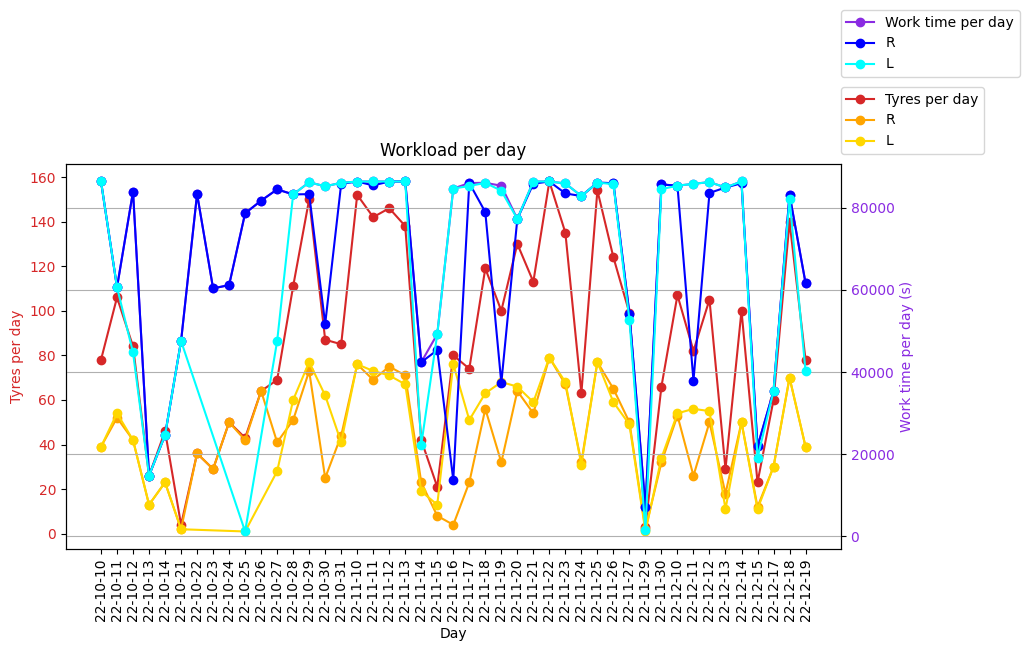

In [192]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1.2), loc=2, borderaxespad=0.)

color = 'blueviolet'
ax_right = ax_left.twinx()
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1.4), loc=2, borderaxespad=0.)
plt.title('Workload per day')
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()


## Dividing the plots

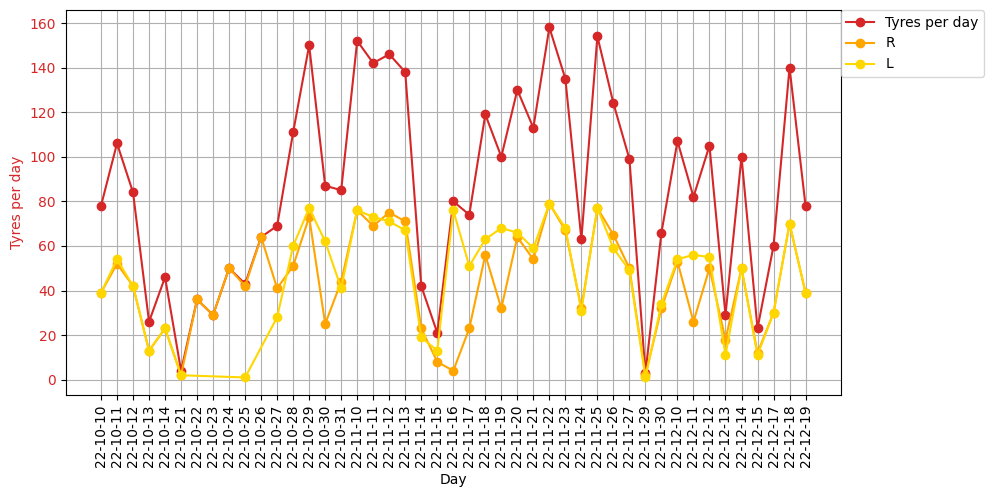

In [193]:
x = mach_tyre_per_day[ColumnsOutput.day]
figure, ax_left = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_left.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_left.set_ylabel('Tyres per day', color=color)
ax_left.set_xlabel('Day')
ax_left.plot(x, mach_tyre_per_day[ColumnsInput.barcode], '-bo', label = 'Tyres per day', color=color)
ax_left.plot(mach_tyre_per_day_per_right[ColumnsOutput.day], mach_tyre_per_day_per_right[ColumnsInput.barcode], '-bo', label = 'R', color='orange')
ax_left.plot(mach_tyre_per_day_per_left[ColumnsOutput.day], mach_tyre_per_day_per_left[ColumnsInput.barcode], '-bo', label = 'L', color='gold')
ax_left.tick_params(axis='y', labelcolor=color)
ax_left.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

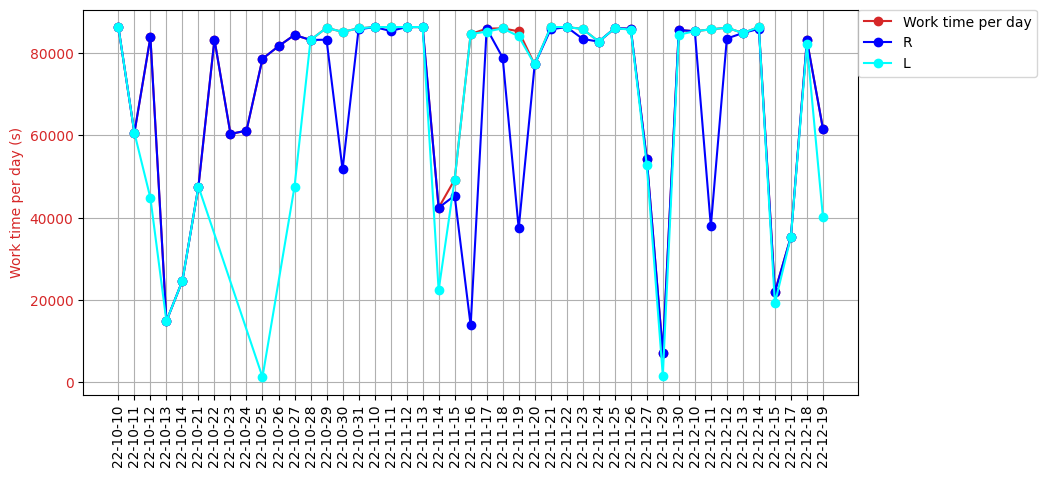

In [194]:
x = working_time_per_day[ColumnsOutput.day]
figure, ax_right = plt.subplots(figsize=(10, 5)) 

color = 'tab:red'
ax_right.set_ylabel('Work time per day (s)', color=color)
ax_right.set_xticklabels(mach_tyre_per_day[ColumnsOutput.day], rotation=90)
ax_right.plot(x, working_time_per_day['work_time'], '-ro', label = 'Work time per day', color=color)
ax_right.plot(working_time_per_day_per_right[ColumnsOutput.day], working_time_per_day_per_right['work_time'], '-ro', label = 'R', color='blue')
ax_right.plot(working_time_per_day_per_left[ColumnsOutput.day], working_time_per_day_per_left['work_time'], '-ro', label = 'L', color='cyan')
ax_right.tick_params(axis='y', labelcolor=color)
ax_right.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.grid(axis='x')
plt.grid(axis='y')
plt.grid(True)
plt.show()

In [195]:
# mean_n_tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode].mean()
# for i in range(len(mach_tyre_per_day)):
#     if mach_tyre_per_day[ColumnsInput.barcode][i] <=  mean_n_tyre_per_day:
#         print('Machine '+str(current_machine)+ " in day " +mach_tyre_per_day[ColumnsOutput.day][i] +' is underperforming')
#         df.drop(df[df[ColumnsOutput.day] == mach_tyre_per_day[ColumnsOutput.day][i]].index, inplace = True)

In [196]:
label_cycle_status = df.sort_values(ColumnsInput.time).groupby([ColumnsOutput.day, ColumnsInput.machine_side,ColumnsInput.barcode], dropna=False)[ColumnsInput.event].agg(['first', 'last']).reset_index()
label_cycle_status[ColumnsOutput.day].nunique()

45

In [197]:
label_cycle_status[ColumnsOutput.status] = False
print(label_cycle_status.columns)
starting_event = ["LO_LOADER_IN_PRESS", "LO_LOADER_IN_PRESS_START"]
ending_event = ["UN_UNLOADER_OUT", "UN_FORK_OUT", "UN_UNLOADER_OUT_STOP", "UN_FORK_OUT_STOP"]

label_cycle_status[ColumnsOutput.status] = label_cycle_status.apply(lambda x: 'CYCLE_COMPLETED' if x['last'] in ending_event else 'CYCLE_ABORTED' if x['first'] in starting_event else 'CYCLE_NOT_STARTED', axis=1)
label_cycle_status.value_counts(ColumnsOutput.status)
label_cycle_status.shape
label_cycle_status_ = label_cycle_status.copy()

Index(['y-m-day', 'ddc_mch_side', 'ddc_barcode', 'first', 'last', 'status'], dtype='object')


<Axes: xlabel='status'>

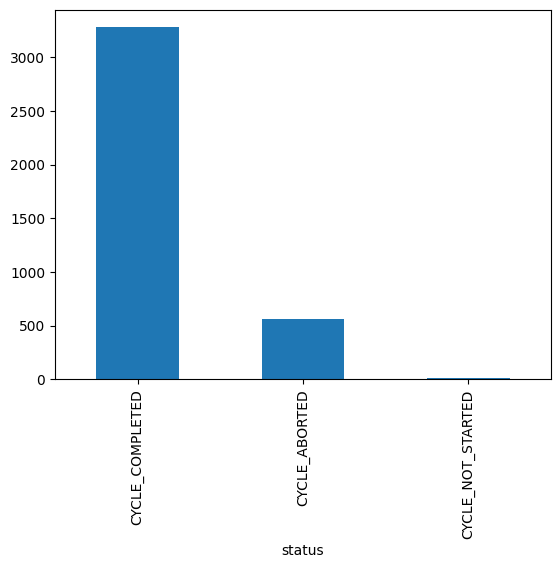

In [198]:
label_cycle_status_[ColumnsOutput.status].value_counts().plot(kind='bar')    

<Axes: xlabel='status'>

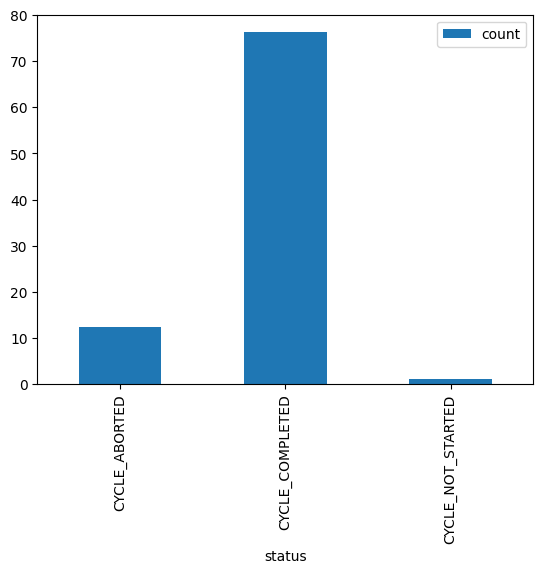

In [199]:
cycle_statuses_per_day = label_cycle_status_.groupby([ColumnsOutput.day])[ColumnsOutput.status].value_counts().reset_index()
cycle_statuses_per_day_mean = cycle_statuses_per_day.groupby([ColumnsOutput.status])['count'].mean().reset_index()
cycle_statuses_per_day_mean.plot(kind='bar', x=ColumnsOutput.status, y='count')

In [200]:
cycle_statuses_per_day = label_cycle_status.groupby([ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
print(len(cycle_statuses_per_day))
print(cycle_statuses_per_day.head())
statuses_per_day = []
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_ABORTED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_NOT_STARTED'], axis=1))
statuses_per_day.append(cycle_statuses_per_day.drop(['CYCLE_COMPLETED', 'CYCLE_ABORTED'], axis=1))
for i in statuses_per_day:
    print(i.shape)
    print(i.columns)
    i.rename(columns={'CYCLE_COMPLETED':'count', 'CYCLE_ABORTED':'count', 'CYCLE_NOT_STARTED':'count'}, inplace=True)
    print(i.columns)
    print('\n')

45
status   y-m-day  CYCLE_ABORTED  CYCLE_COMPLETED  CYCLE_NOT_STARTED
0       22-10-10              8               70                  0
1       22-10-11             16               90                  0
2       22-10-12              8               76                  0
3       22-10-13              4               22                  0
4       22-10-14              6               40                  0
(45, 2)
Index(['y-m-day', 'CYCLE_COMPLETED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(45, 2)
Index(['y-m-day', 'CYCLE_ABORTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')


(45, 2)
Index(['y-m-day', 'CYCLE_NOT_STARTED'], dtype='object', name='status')
Index(['y-m-day', 'count'], dtype='object', name='status')




3


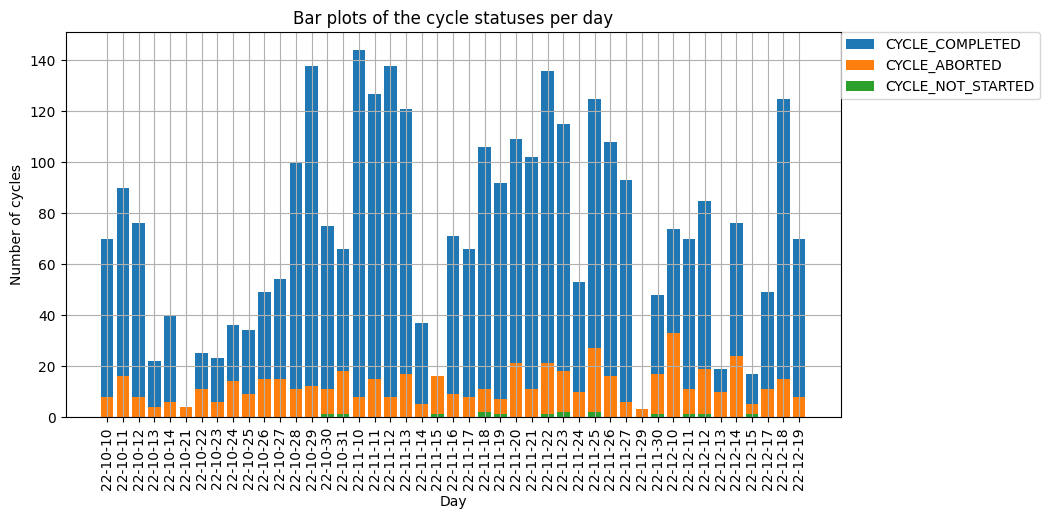

In [201]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day))
status_names = ['CYCLE_COMPLETED', 'CYCLE_ABORTED', 'CYCLE_NOT_STARTED']
for i in range(len(statuses_per_day)):
    ax.bar(statuses_per_day[i][ColumnsOutput.day], statuses_per_day[i]['count'], label = status_names[i])
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)
plt.show()


### Checking right and left sides as well

In [202]:
label_cycle_status_right = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'R']
label_cycle_status_left = label_cycle_status[label_cycle_status[ColumnsInput.machine_side] == 'L']
cycle_statuses_per_day_left = label_cycle_status_left.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()
cycle_statuses_per_day_left
statuses_per_day_left = []
for status in cycle_statuses_per_day_left[ColumnsOutput.status].unique():
    statuses_per_day_left.append(cycle_statuses_per_day_left[cycle_statuses_per_day_left[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
for i in statuses_per_day_left:
    print(i.shape)
    print('\n')
cycle_statuses_per_day_right = label_cycle_status_right.groupby([ColumnsInput.machine_side,ColumnsOutput.day], dropna=False)[ColumnsOutput.status].value_counts().reset_index()
cycle_statuses_per_day_right
statuses_per_day_right = []
for status in cycle_statuses_per_day_right[ColumnsOutput.status].unique():
    statuses_per_day_right.append(cycle_statuses_per_day_right[cycle_statuses_per_day_right[ColumnsOutput.status] == status].reset_index().drop('index', axis = 1))
for i in statuses_per_day_right:
    print(i.shape)
    print('\n')


cycle_statuses_per_day_ = label_cycle_status.groupby([ColumnsOutput.day, ColumnsInput.machine_side], dropna=False)[ColumnsOutput.status].value_counts().unstack(fill_value=0).reset_index()
cycle_statuses_per_day_right = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'R'].reset_index()
cycle_statuses_per_day_left = cycle_statuses_per_day_[cycle_statuses_per_day_[ColumnsInput.machine_side] == 'L'].reset_index()
print(cycle_statuses_per_day_right)




(38, 4)


(41, 4)


(10, 4)


(43, 4)


(45, 4)


(4, 4)


status  index   y-m-day ddc_mch_side  CYCLE_ABORTED  CYCLE_COMPLETED  CYCLE_NOT_STARTED
0           1  22-10-10            R              6               33                  0
1           3  22-10-11            R             10               42                  0
2           5  22-10-12            R              6               36                  0
3           7  22-10-13            R              2               11                  0
4           9  22-10-14            R              4               19                  0
5          11  22-10-21            R              2                0                  0
6          12  22-10-22            R             11               25                  0
7          13  22-10-23            R              6               23                  0
8          14  22-10-24            R             14               36                  0
9          16  22-10-25            R              8          

3


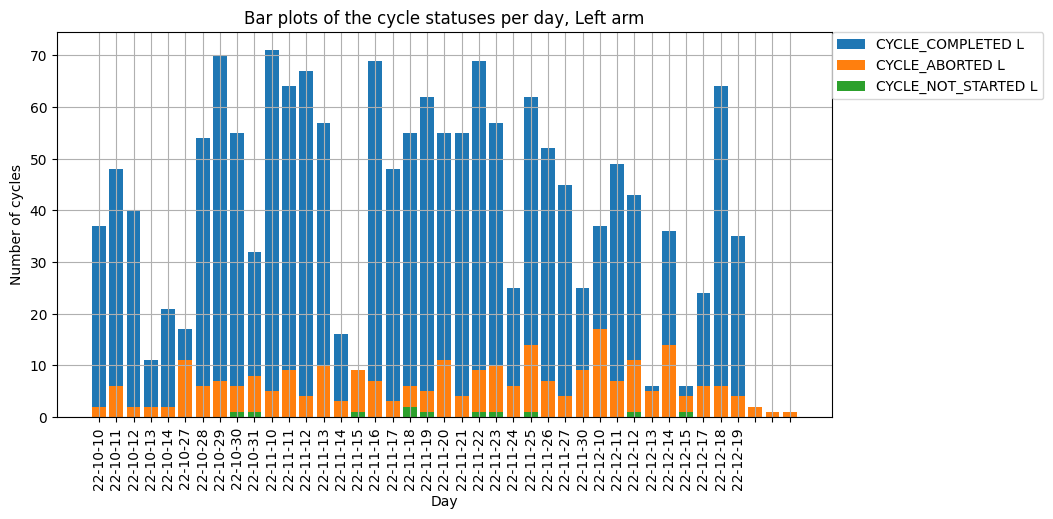

In [203]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_left[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day_left))
plt.bar(statuses_per_day_left[0][ColumnsOutput.day], statuses_per_day_left[0]['count'], label = status_names[0] +' L')
plt.bar(statuses_per_day_left[1][ColumnsOutput.day], statuses_per_day_left[1]['count'], label = status_names[1] + ' L')
plt.bar(statuses_per_day_left[2][ColumnsOutput.day], statuses_per_day_left[2]['count'], label = status_names[2] + ' L')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Left arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

45


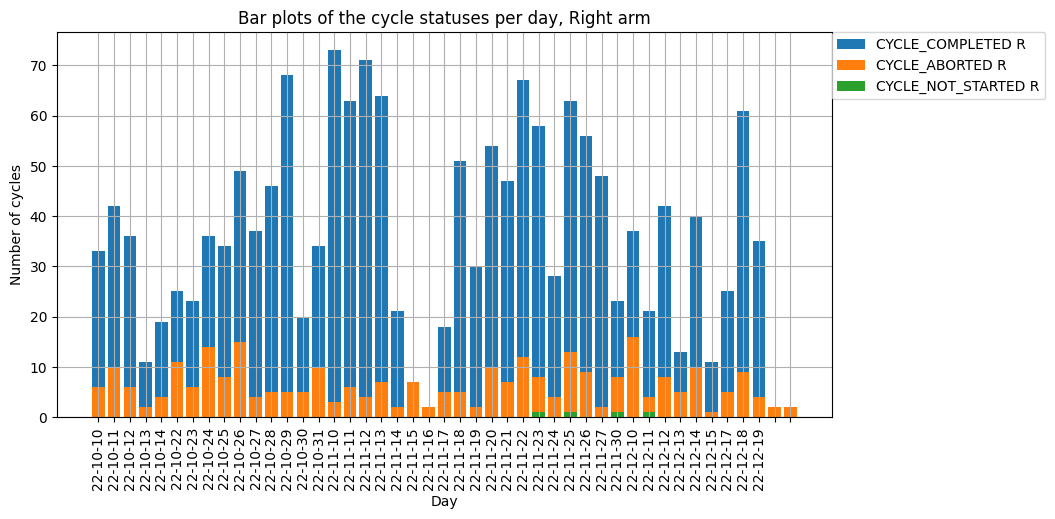

In [204]:
figure, ax = plt.subplots(figsize=(10, 5))
ax.set_xticklabels(statuses_per_day_right[0][ColumnsOutput.day], rotation=90)
print(len(statuses_per_day[2]))
plt.bar(statuses_per_day_right[0][ColumnsOutput.day], statuses_per_day_right[0]['count'], label = status_names[0] + ' R')
plt.bar(statuses_per_day_right[1][ColumnsOutput.day], statuses_per_day_right[1]['count'], label = status_names[1] + ' R')
plt.bar(statuses_per_day_right[2][ColumnsOutput.day], statuses_per_day_right[2]['count'], label = status_names[2] + ' R')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.title('Bar plots of the cycle statuses per day, Right arm')
plt.xlabel('Day')
plt.ylabel('Number of cycles')
plt.grid(True)

In [205]:
# figure, ax = plt.subplots(figsize=(10, 5))
# print(len(statuses_per_day[0]))
# #ax.set_xticklabels(statuses_per_day[0][ColumnsOutput.day], rotation=90)
# print(len(statuses_per_day_right[2]), len(statuses_per_day_left[2]))

# for i in range(len(statuses_per_day)-1):
#     x = np.arange(len(days))
#     x1 = [i + 0.4 for i in x]
#     ax.bar(x, statuses_per_day_right[i]['count'], width = 0.4, label = str(statuses_per_day_right[i][ColumnsOutput.status].unique()))
#     ax.bar(x1, statuses_per_day_left[i]['count'], width = 0.4, label = str(statuses_per_day_left[i][ColumnsOutput.status].unique()))

# plt.grid(True)
# plt.show()

## Getting all previous indices per day fro the machines

In [206]:

len(days)



45

In [207]:
# variables = [mach_tyre_per_day, mach_tyre_per_day_per_left, mach_tyre_per_day_per_right ,working_time_per_day, working_time_per_day_per_left, 
#              working_time_per_day_per_right, statuses_per_day_left[0], statuses_per_day_left[1], statuses_per_day_left[2], 
#              statuses_per_day_right[0], statuses_per_day_right[1], statuses_per_day_right[2], statuses_per_day[0], statuses_per_day[1], 
#              statuses_per_day[2]] # TODO issue on index
tyre_per_day = mach_tyre_per_day[ColumnsInput.barcode]
tyre_per_day_left = mach_tyre_per_day_per_left[ColumnsInput.barcode]


tyre_per_day_right = mach_tyre_per_day_per_right[ColumnsInput.barcode]
work_time_per_day = working_time_per_day['work_time']
work_time_per_day_left = working_time_per_day_per_left['work_time']
work_time_per_day_right = working_time_per_day_per_right['work_time']
status_per_day_left_1 = cycle_statuses_per_day_left['CYCLE_COMPLETED']
status_per_day_left_2 =cycle_statuses_per_day_left['CYCLE_ABORTED']
status_per_day_left_3 = cycle_statuses_per_day_left['CYCLE_NOT_STARTED']
status_per_day_right_1 = cycle_statuses_per_day_right['CYCLE_COMPLETED']
status_per_day_right_2 = cycle_statuses_per_day_right['CYCLE_ABORTED']
status_per_day_right_3 = cycle_statuses_per_day_right['CYCLE_NOT_STARTED']
status_per_day_1 = statuses_per_day[0]['count']
status_per_day_2 = statuses_per_day[1]['count']
status_per_day_3 = statuses_per_day[2]['count']

# colums_name = ['day', 'tyre_per_day', 'tyre_per_day_left', 'tyre_per_day_right', 'work_time_per_day', 'work_time_per_day_left', 'work_time_per_day_right','completed_jobs_left', 'aborted_jobs_left', 'not_started_jobs_left', 'completed_jobs_right', 'aborted_jobs_right', 'not_started_jobs_right', 'completed_jobs', 'aborted_jobs', 'not_started_jobs']

mach_processed_df = pd.DataFrame()
mach_processed_df['day'] = days
mach_processed_df['tyre_per_day'] = tyre_per_day
mach_processed_df['tyre_per_day_left'] = tyre_per_day_left
mach_processed_df['tyre_per_day_right'] = tyre_per_day_right
mach_processed_df['work_time_per_day'] = work_time_per_day
mach_processed_df['work_time_per_day_left'] = work_time_per_day_left
mach_processed_df['work_time_per_day_right'] = work_time_per_day_right
mach_processed_df['completed_jobs_left'] = status_per_day_left_1
mach_processed_df['aborted_jobs_left'] = status_per_day_left_2
mach_processed_df['not_started_jobs_left'] = status_per_day_left_3
mach_processed_df['completed_jobs_right'] = status_per_day_right_1
mach_processed_df['aborted_jobs_right'] = status_per_day_right_2
mach_processed_df['not_started_jobs_right'] = status_per_day_right_3
mach_processed_df['completed_jobs'] = status_per_day_1
mach_processed_df['aborted_jobs'] = status_per_day_2
mach_processed_df['not_started_jobs'] = status_per_day_3

mach_processed_df.sort_values(by=['day'], inplace = True)
#mach_processed_df.fillna(0, inplace = True)
mach_processed_df


,day,tyre_per_day,tyre_per_day_left,tyre_per_day_right,work_time_per_day,work_time_per_day_left,work_time_per_day_right,completed_jobs_left,aborted_jobs_left,not_started_jobs_left,completed_jobs_right,aborted_jobs_right,not_started_jobs_right,completed_jobs,aborted_jobs,not_started_jobs
0,22-10-10,78,39.0,39,86396.0,86396.0,86396.0,37.0,2.0,0.0,33,6,0,70,8,0
1,22-10-11,106,54.0,52,60630.0,60630.0,60629.0,48.0,6.0,0.0,42,10,0,90,16,0
2,22-10-12,84,42.0,42,83942.0,44762.0,83942.0,40.0,2.0,0.0,36,6,0,76,8,0
3,22-10-13,26,13.0,13,14796.0,14796.0,14795.0,11.0,2.0,0.0,11,2,0,22,4,0
4,22-10-14,46,23.0,23,24653.0,24653.0,24652.0,21.0,2.0,0.0,19,4,0,40,6,0
5,22-10-21,4,2.0,2,47555.0,47555.0,47555.0,0.0,2.0,0.0,0,2,0,0,4,0
6,22-10-22,36,1.0,36,83357.0,1185.0,83357.0,0.0,1.0,0.0,25,11,0,25,11,0
7,22-10-23,29,28.0,29,60374.0,47535.0,60374.0,17.0,11.0,0.0,23,6,0,23,6,0
8,22-10-24,50,60.0,50,61165.0,83246.0,61165.0,54.0,6.0,0.0,36,14,0,36,14,0
9,22-10-25,43,77.0,42,78660.0,86201.0,78660.0,70.0,7.0,0.0,34,8,0,34,9,0


<Axes: >

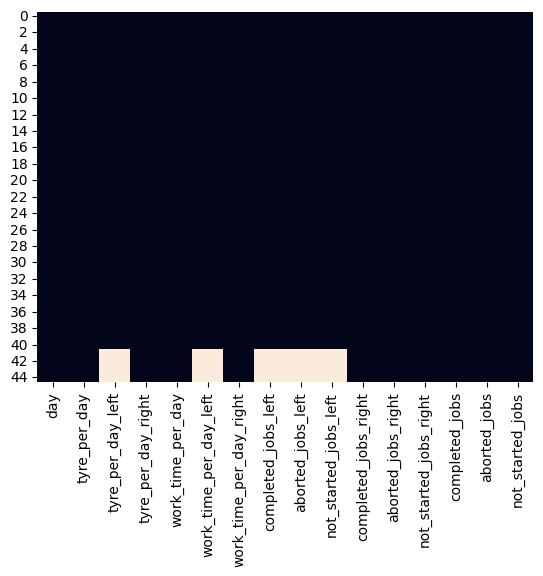

In [208]:
sns.heatmap(mach_processed_df.isna(), cbar=False)

### Correlation between the tyres produced and the completed cycles

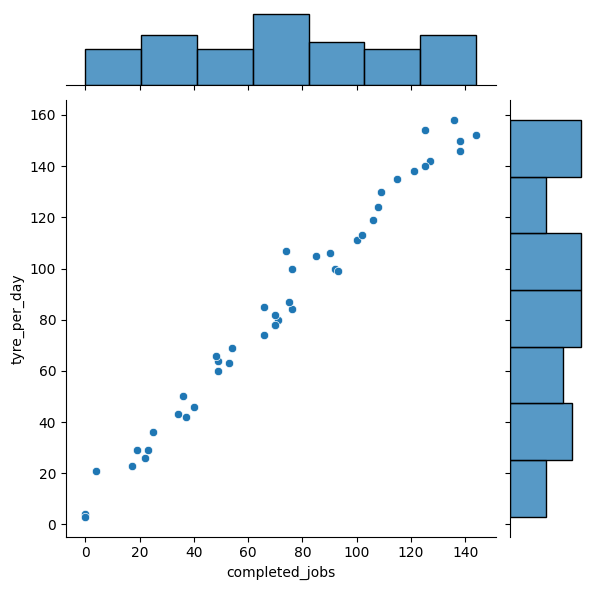

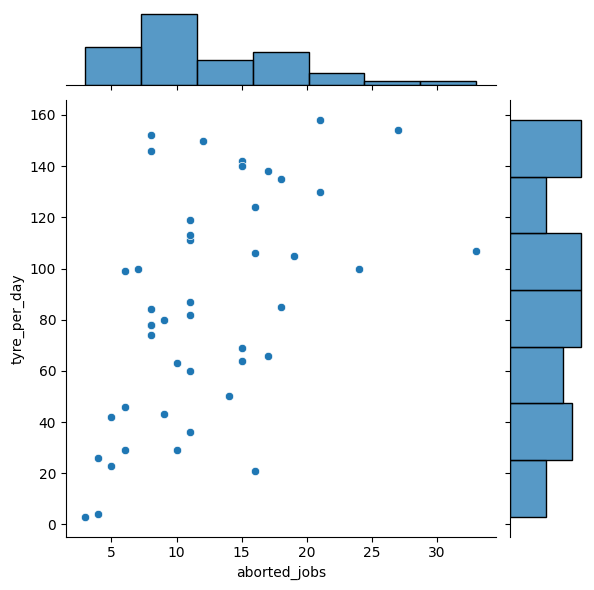

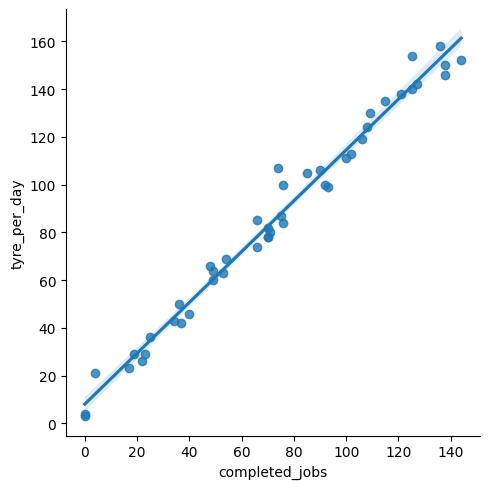

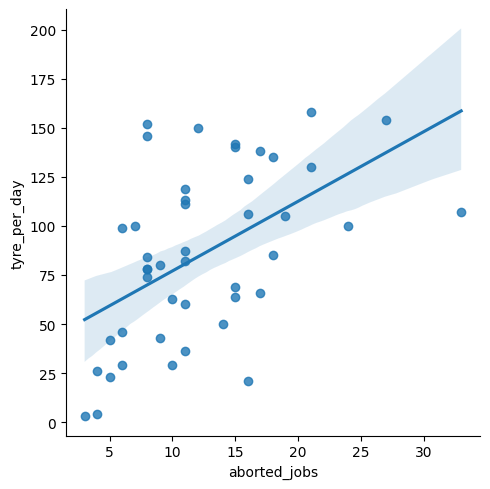

In [209]:
sns.jointplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day',data=mach_processed_df)

### Correlation between the working time and the completed cycle

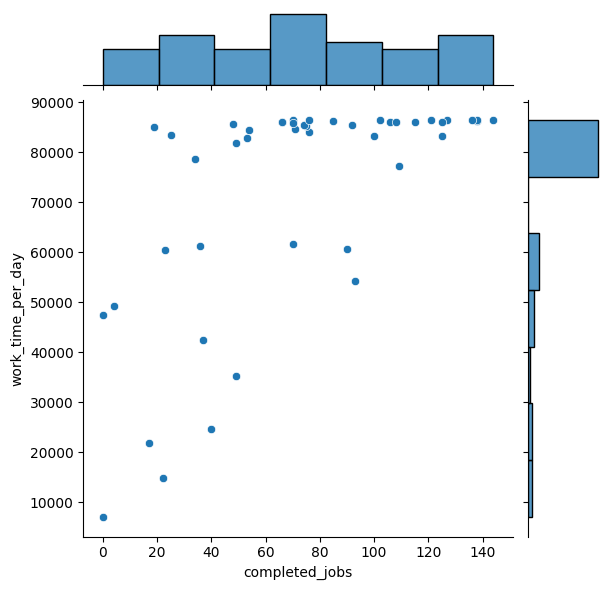

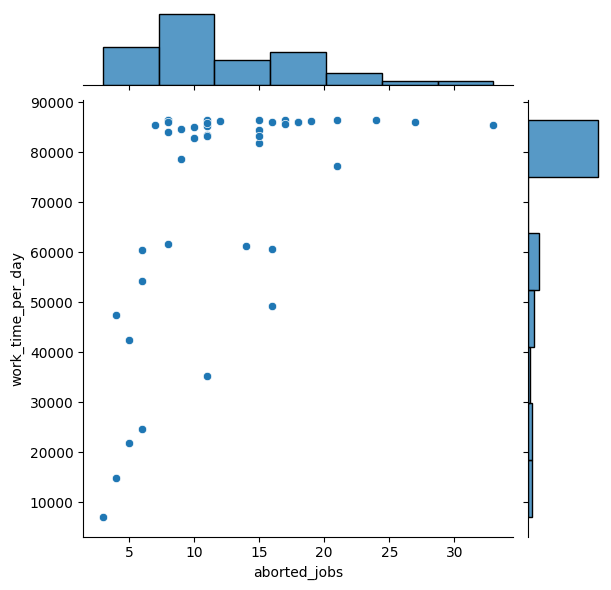

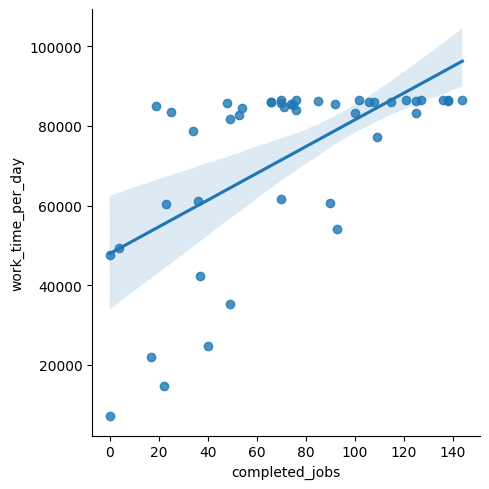

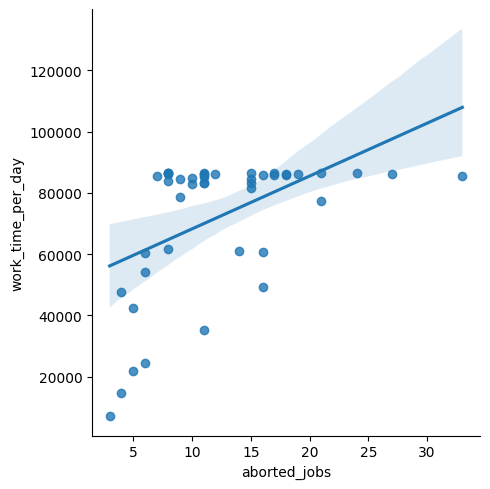

In [210]:
sns.jointplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns. jointplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day',data=mach_processed_df)

### Correlation per sides

Completed jobs correlation with the tyre per day by side

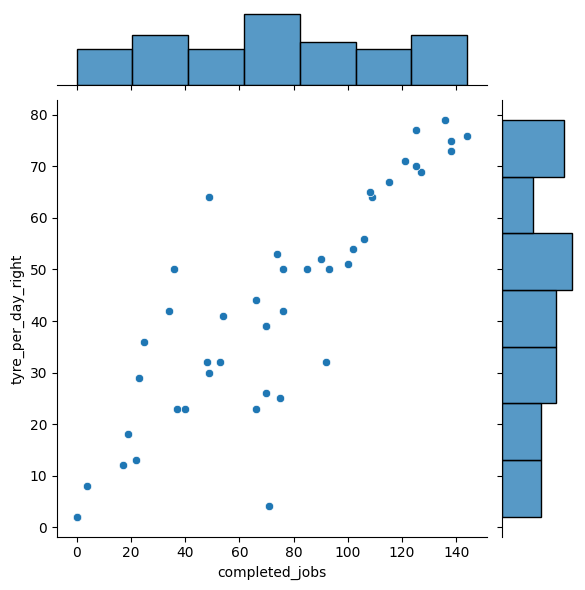

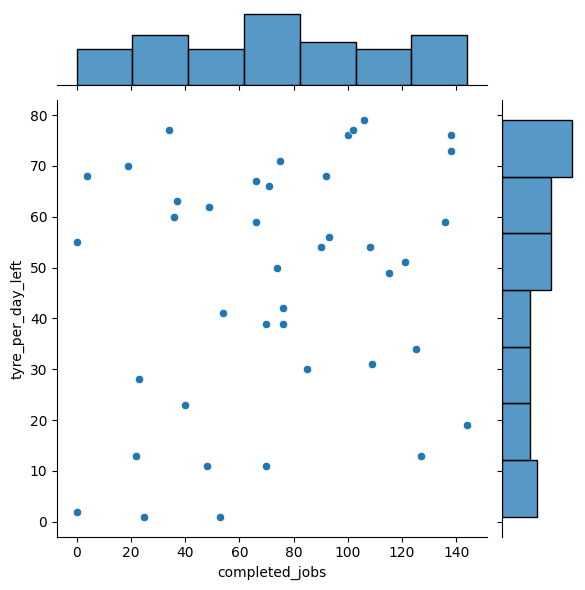

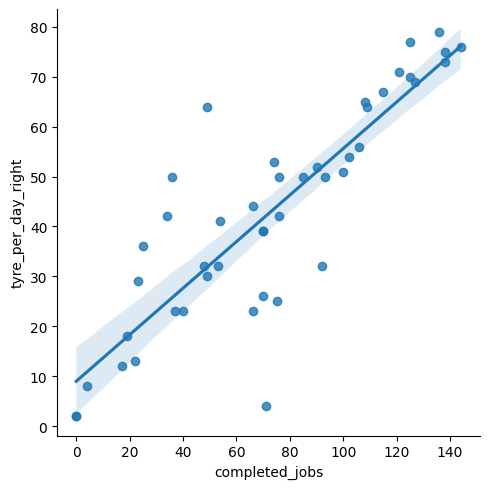

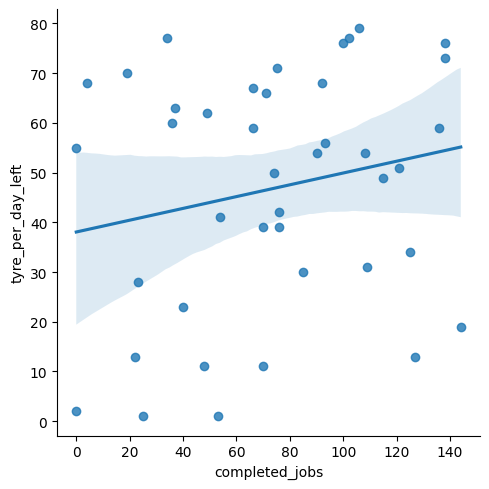

In [211]:
sns.jointplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='tyre_per_day_left',data=mach_processed_df)

Aborted jobs correlation with the tyre per day by side

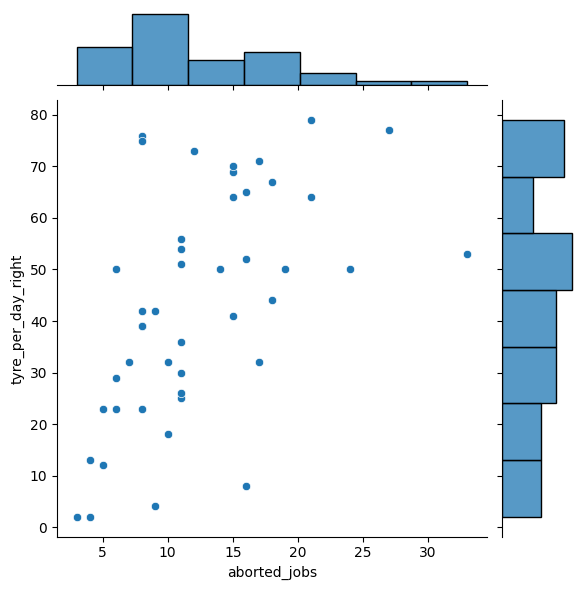

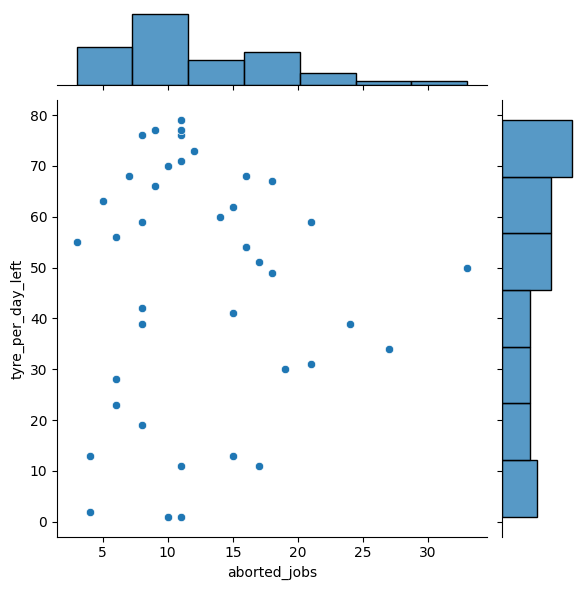

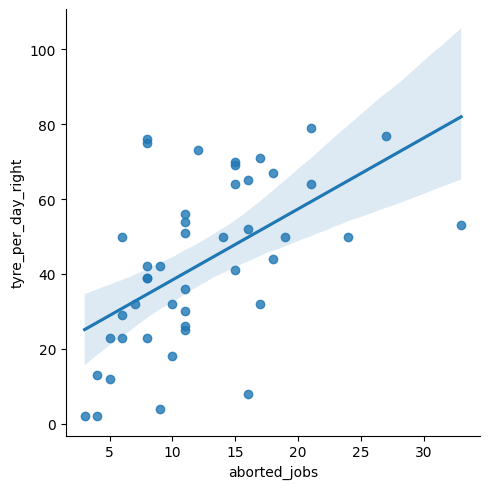

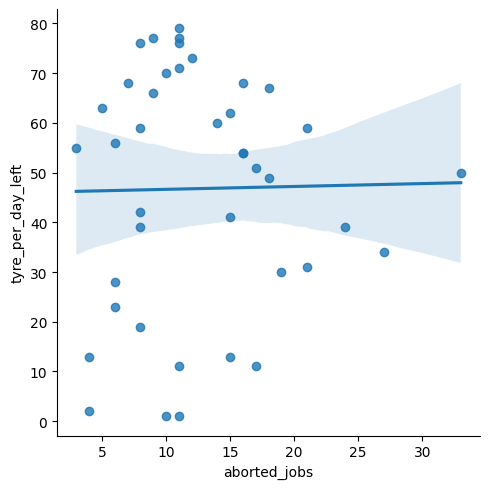

In [212]:
sns.jointplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='tyre_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='tyre_per_day_left',data=mach_processed_df)

Jobs correlation with the tyre per day by side


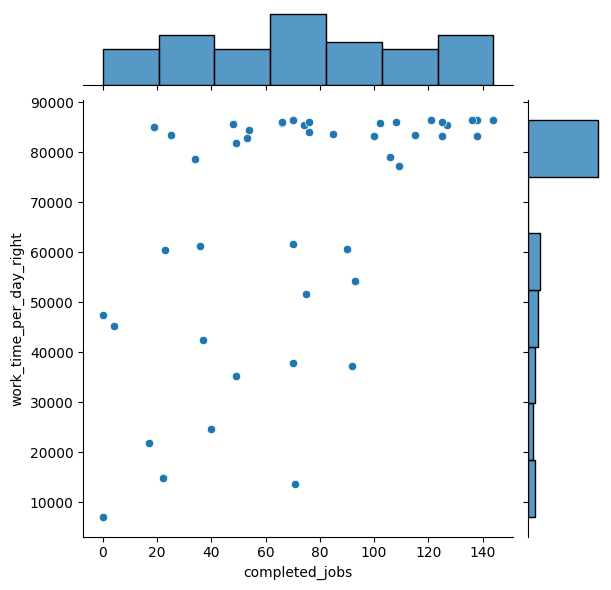

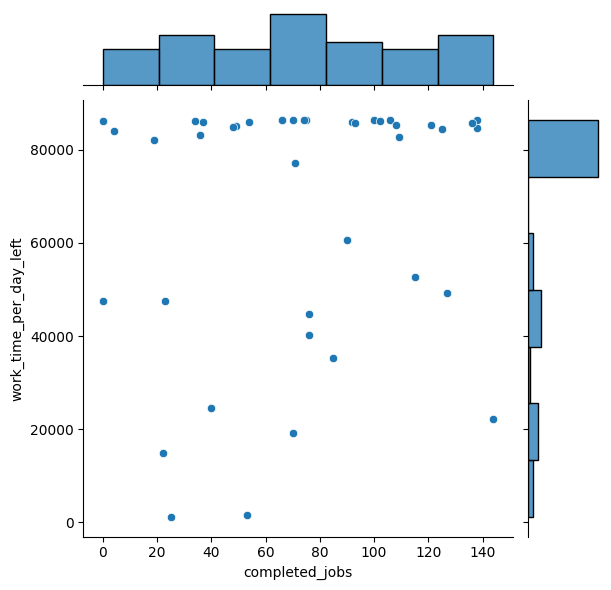

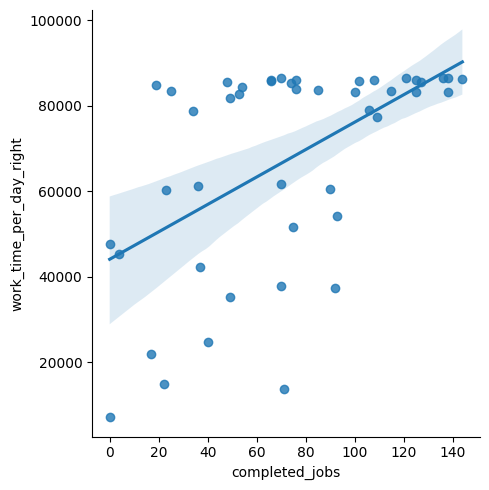

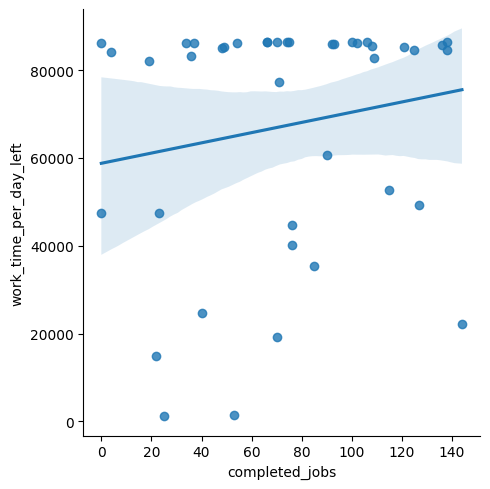

In [213]:
sns.jointplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='completed_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='completed_jobs',y='work_time_per_day_left',data=mach_processed_df)

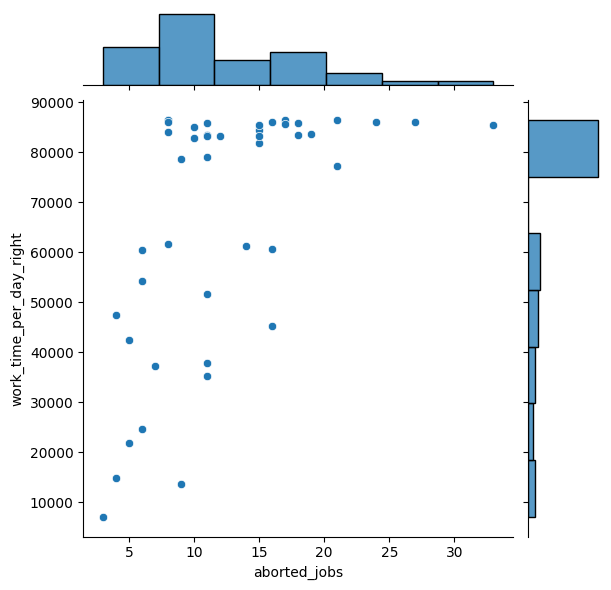

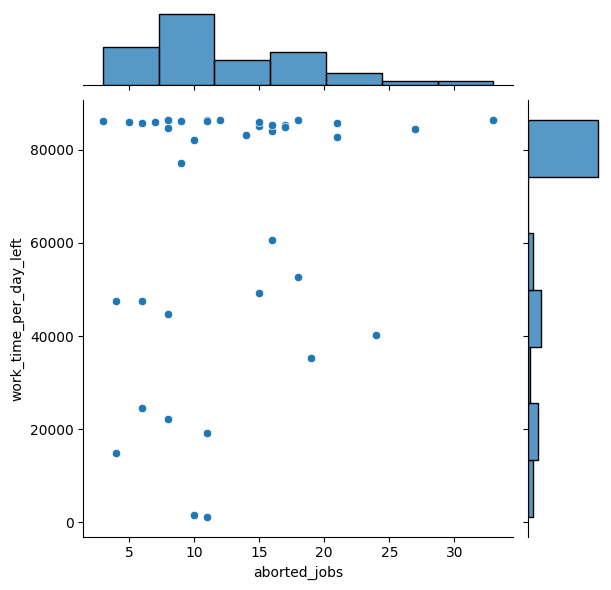

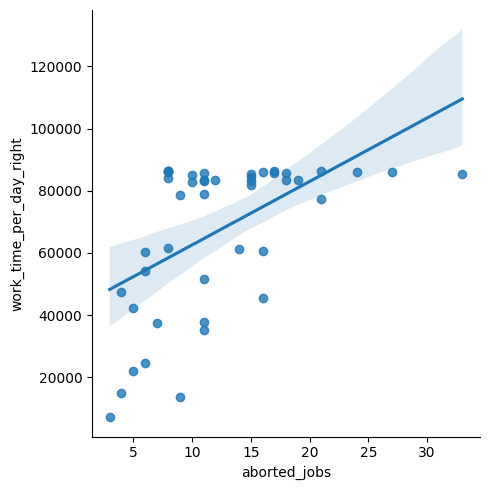

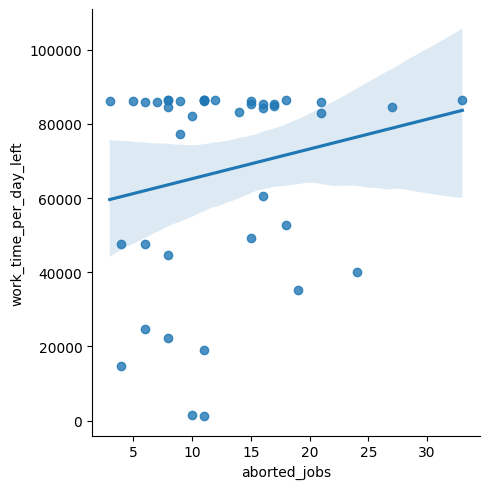

In [214]:
sns.jointplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df,kind='scatter')
sns.jointplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df,kind='scatter')
sns.lmplot(x='aborted_jobs',y='work_time_per_day_right',data=mach_processed_df)
sns.lmplot(x='aborted_jobs',y='work_time_per_day_left',data=mach_processed_df)